In [143]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [144]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../energy')

In [218]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [159]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [307]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

#     def __call__(self, x):
#         x = self.encode_layer(x)
#         x = self.ano1(x)
#         x = self.ano2(x)
#         x = self.ano3(x)
#         x = self.decode_layer(x)
#         return x
    
    def __call__(self, x):
        f = self.encode_layer(x)
        f = self.ano1(f)
        f = self.ano2(f)
        f = self.ano3(f)
        f = self.decode_layer(f)
        return f + jnp.mean(x, axis = -1)[:,:,:,None]

In [370]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)

In [309]:
# https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
import pandas as pd
energy = pd.read_excel('../data/tx_energy.xlsx')

In [310]:
energy_curves =  energy.groupby('Local date')['Demand'].apply(list).reset_index()
energy_curves = np.array(energy_curves)

In [311]:
dts = energy_curves2[:,0]
fns = energy_curves2[:,1]

In [333]:
# transform
fns = energy_curves2[:,1]
fns = [np.array(f) for f in fns]
fns = [jax.image.resize(f, 24, 'bicubic') for f in fns]
fns = np.array(fns)

# backfill missing
missing = jnp.sum(jnp.isnan(fns), axis = 1) > 0
for i in range(fns.shape[0]):
    if missing[i]:
        fns[i] = fns[i-1]

# rescale
# fns = (fns - jnp.mean(fns, axis = 0)[None,:]) / jnp.std(fns, axis = 0)[None,:]
fns = (fns - jnp.mean(fns, axis = 1)[:,None]) / jnp.std(fns, axis = 1)[:,None]
fns = jnp.array(fns)

In [377]:
lag = 1
lead = 1
x, y = split_data(fns, lag, 1)
ntrain, nval = 1500, 2500

xtrain = x[:ntrain].reshape(-1, 1, 24, lag)
ytrain = y[:ntrain].reshape(-1, 1, 24, lead)

xval = x[ntrain:nval].reshape(-1, 1, 24, lag)
yval = y[ntrain:nval].reshape(-1, 1, 24, lead)

xtest = x[nval:].reshape(-1, 1, 24, lag)
ytest = y[nval:].reshape(-1, 1, 24, lead)

train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [381]:
epochs = 50
trace = []

model = DeepANO(lag, 32, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [382]:
quant = DeepANO(lag, 32, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [383]:
yval_hat = model(xval)
ytest_hat = model(xtest)
yval_quant = quant(xval)
ytest_quant = quant(xtest)

In [384]:
jnp.mean((yval_hat - yval)**2), jnp.mean((ytest_hat - ytest)**2)

(Array(0.2160308, dtype=float32), Array(0.18059681, dtype=float32))

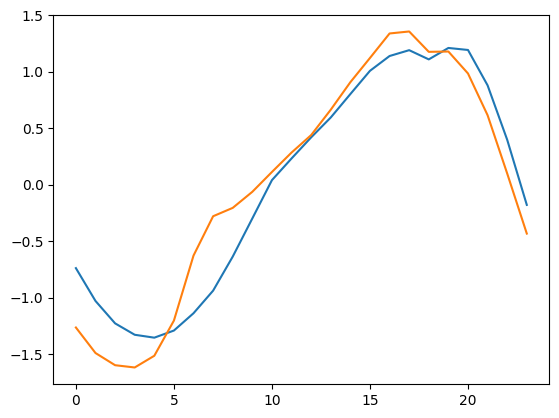

In [385]:
plt.plot(yval_hat.squeeze()[800])
plt.plot(yval.squeeze()[800])

In [521]:
# UQNO lambda estimate
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 24
tau = 20 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval.squeeze() - yval_hat.squeeze()) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha) * 1/10
lam_uqno

Array(1.9713188, dtype=float32)

In [548]:
(yval - yval_hat).shape, rval.shape

((1000, 24), (1000, 24))

In [557]:
nproj = 24
gamma1 = 0.1
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

lsc1_rc = []
lsc1_width = []

conf_rc = []
conf_width = []

supr_rc = []
supr_width = []

uqn1_rc = []
uqn1_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

# rval_std = np.std(rval, axis = 0)[None,:]
# rval = rval / rval_std
# rtest = rtest / rval_std

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0]):
# for i in trange(0, 100):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.mean(supr_upper - supr_lower))
    
    # SUPR
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.mean(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)

  0%|          | 0/1021 [00:00<?, ?it/s]

In [558]:
noise_sd = np.std(rtest, axis = 1)[:conf_rc.shape[0]]

risk_control = np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99)

width = np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width)

risk_cor = np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1]

width_cor = 0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [559]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 0.967 -0.536  3.789  0.   ]
 [ 0.914 -0.717  3.034  0.   ]
 [ 0.969 -0.43   4.717  0.593]
 [ 0.941 -0.244  1.871  0.717]]


In [560]:
for i in range(4):
    for j in range(4):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.967 & -0.536 & 3.789 & 0.000 \\
0.914 & -0.717 & 3.034 & 0.000 \\
0.969 & -0.430 & 4.717 & 0.593 \\
0.941 & -0.244 & 1.871 & 0.717 \\


In [561]:
arclen = jnp.sum(jnp.diff(rtest, axis = 1)**2, axis = 1)

(Array(471, dtype=int32), Array(647, dtype=int32))

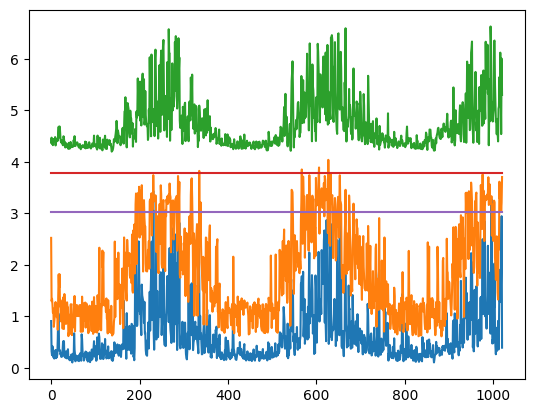

In [565]:
plt.plot(2 * noise_sd)
plt.plot(lsc1_width)
plt.plot(uqn1_width)
plt.plot(conf_width)
plt.plot(supr_width)
jnp.argmin(arclen), jnp.argmax(arclen)

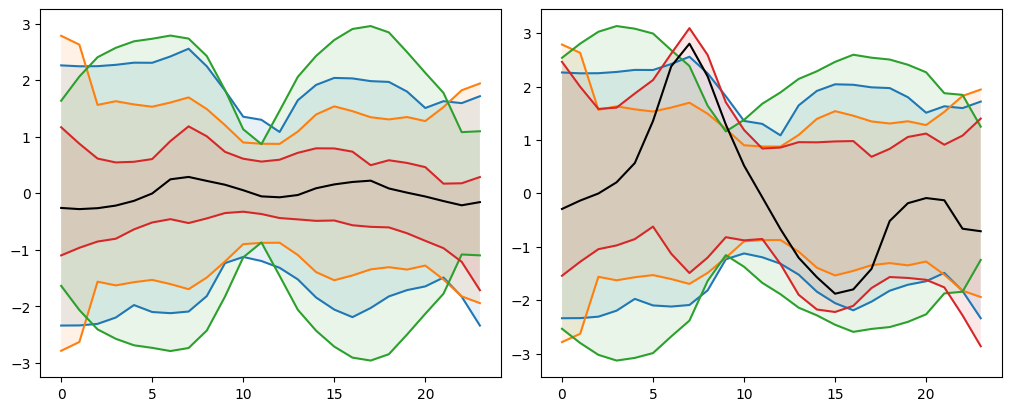

In [572]:
### examples
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))

n = 10
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n], uqn1_upper[n]

ax[0].plot(conf_upper.squeeze(), c = 'C0')
ax[0].plot(conf_lower.squeeze(), c = 'C0')
ax[0].plot(supr_upper.squeeze(), c = 'C1')
ax[0].plot(supr_lower.squeeze(), c = 'C1')
ax[0].plot(uqno_upper, c = 'C2')
ax[0].plot(uqno_lower, c = 'C2')
ax[0].plot(lsc1_upper, c = 'C3')
ax[0].plot(lsc1_lower, c = 'C3')
ax[0].plot(rtest[n], c = 'black')

s = np.arange(24)
ax[0].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)

n = 647
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n], uqn1_upper[n]

ax[1].plot(conf_upper.squeeze(), c = 'C0')
ax[1].plot(conf_lower.squeeze(), c = 'C0')
ax[1].plot(supr_upper.squeeze(), c = 'C1')
ax[1].plot(supr_lower.squeeze(), c = 'C1')
ax[1].plot(uqno_upper, c = 'C2')
ax[1].plot(uqno_lower, c = 'C2')
ax[1].plot(lsc1_upper, c = 'C3')
ax[1].plot(lsc1_lower, c = 'C3')
ax[1].plot(rtest[n], c = 'black')

s = np.arange(24)
ax[1].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
plt.show()